# Overview
Many useful calculations related to churn are summarized here. This document is intended to be a source of truth for the methodologies of churn calculation, as well as some quick formulas for understanding churn.

# Expected Sub Count as a Function of gross adds and churn rate


In this section we derive an estimate for the estimated eventual sub count of a system where the gross add rate and churn rate are known.

Let $g(t)$ represent the quantity of gross adds per month, $c(t)$ represent the monthly churn rate for a system, $n(t)$ represent the net adds for the system, and $s(t)$ represent the sub count for the system at any given month $t$. Then net adds is given by the equation

$$n(t)=g(t)−c(t)∗s(t)$$
 
That is, net adds represents the change in sub count over a period of time and is accounted for by the difference of gross adds to the system and churn from the system. Rewriting we obtain

$$Δs(t)=g(t)−c(t)∗s(t)$$
 
Treating this as a differential equation, we get a separable equation with the form

$$\frac{ds}{g(t)−c(t)∗s(t)}=t∗dt$$

Assuming $g$ and $c$ are constants, this gives

$$s=Ae^{−ct}+\frac{g}{c}$$
 
This solution then has an equilibrium at the ratio $\frac{g}{c}$. This means that over time, s trends toward $\frac{g}{c}$ over time, giving us an upper bound estimate on the sub count for the network. This means that starting above or below the quantity $\frac{g}{c}$, the sub count will head toward $\frac{g}{c}$ over time. See the graph below.

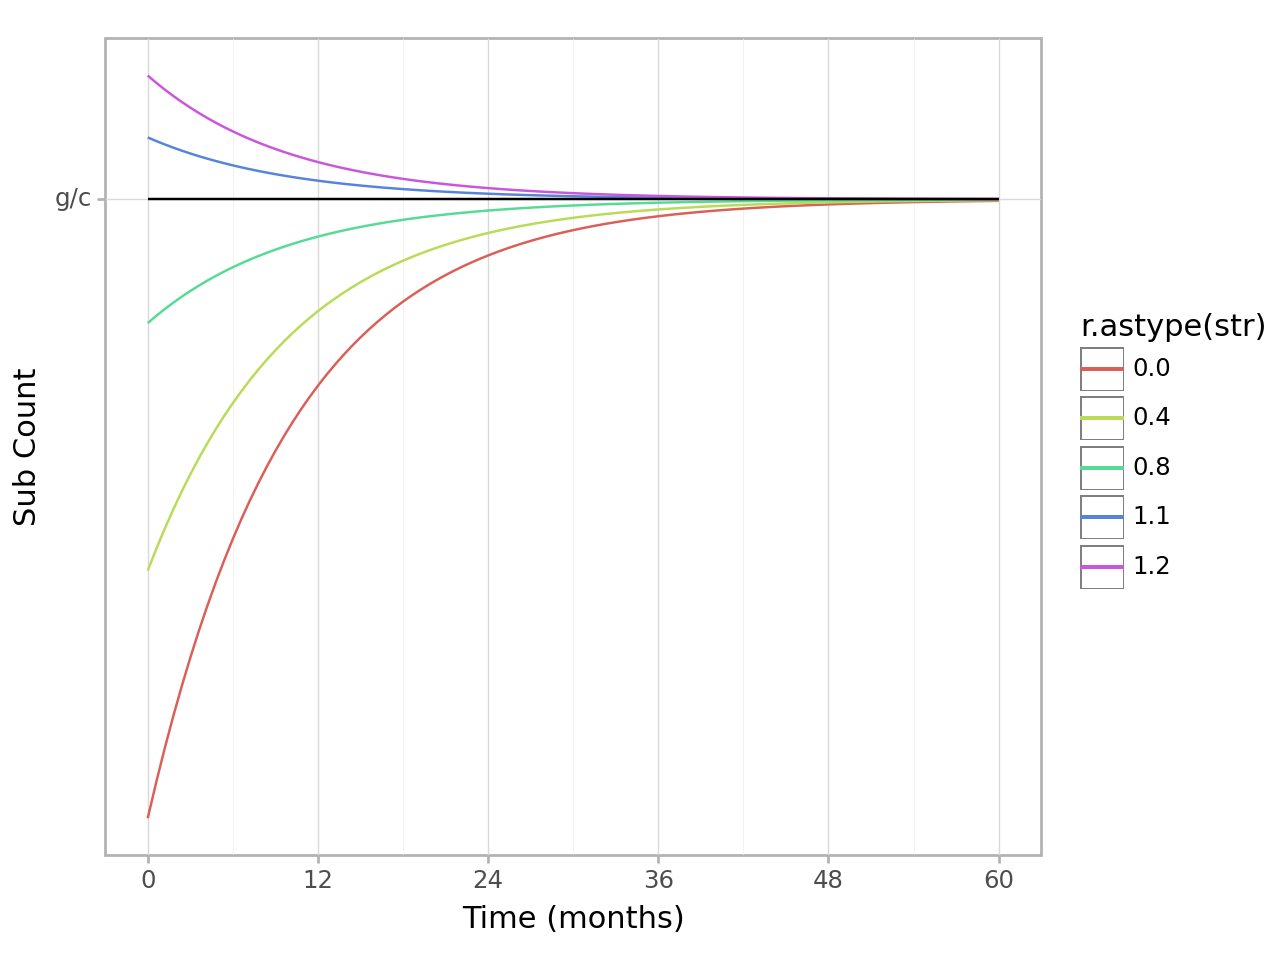

<Figure Size: (640 x 480)>

In [1]:
import pandas as pd
import numpy as np
from plotnine import *
from scipy.integrate import odeint

multiplier = 10.0

func = lambda y, x : 1 - y / multiplier

x = np.linspace(0, 60, 101)

df_list = []
for mul in [0.0, 0.4, 0.8, 1.1, 1.2]:
    y = odeint(func, mul * multiplier, x)
    df = pd.DataFrame(data={'x': x, 'y': y[:, 0], 'r': np.repeat(mul, 101)})
    df_list.append(df)

constant_line = pd.DataFrame(data={'x': x, 'y': np.repeat(multiplier, 101), 'r': np.repeat(mul, 101)})

plot_df = pd.concat(df_list)

(
    ggplot(data=plot_df) +
    geom_line(aes(x='x', y='y', group='r', color='r.astype(str)')) +
    geom_line(data=constant_line, mapping=aes(x='x', y='y', group='r'), color='black') +
    theme_light() +
    scale_y_continuous(breaks = [multiplier], labels = ["g/c"]) +
    scale_x_continuous(breaks = [12 * x for x in range(0, 6)]) +
    xlab('Time (months)') +
    ylab('Sub Count')
)

More sophisticated analyses are needed to determine things like 'can we support a given number of gross adds?', 'what will our churn rate be?', as well as determining if we can hit a given gross add target. The ratio $\frac{g}{c}$ is solely meant to give a quick way to calculate eventual sub count. ARPU is needed to understand revenue streams and yield is needed for greater understanding of the consumption of bandwidth.

# We calculate $\frac{g}{c}$ for several values of $g$ and $c$ below

In [2]:
from itertools import product


gs = [10000.0, 15000.0, 20000.0, 25000.0, 30000.0]
cs = [0.02, 0.025, 0.03, 0.035]
table = []
for g,c in product(gs, cs):
    table.append([g, c, g / c])

pd.options.display.float_format = '{:,}'.format
display = pd.DataFrame(table, columns=['g', 'c', 'g/c'])
display.g = display.g.astype(int).astype(float)
display['g/c'] = display['g/c'].astype(int).astype(float)
display.index.name = 'row'
display

,g,c,g/c
row,,,
0,"10,000.0",0.02,"500,000.0"
1,"10,000.0",0.025,"400,000.0"
2,"10,000.0",0.03,"333,333.0"
3,"10,000.0",0.035,"285,714.0"
4,"15,000.0",0.02,"750,000.0"
5,"15,000.0",0.025,"600,000.0"
6,"15,000.0",0.03,"500,000.0"
7,"15,000.0",0.035,"428,571.0"
8,"20,000.0",0.02,"1,000,000.0"


# How Long Does It Take to Change Churn Rate?
There are at least three areas one can put energy into changing the churn rate. Marketing to expected long-life subs, acquiring subs with longer expected lifetimes, or making retention offers to existing subs. This analysis collapses the marketing and acquisition steps into one piece.

In [3]:
simulation_months = 24
sub_count = 560000.0

def iterate_sim(i, acq, a, b, r, c_a, c_b, r_r):
    r = np.append(r, [b[i-1]*c_b[i] + a[i-1]*c_a[i] - r[i-1] * r_r[i]])
    a = np.append(a, [a[i-1] + acq - a[i-1]*c_a[i]])
    b = np.append(b, [b[i-1] - b[i-1]*c_b[i] + r[i-1] * r_r[i]])
    return a, b, r

def run_scenario(ac, c_a, c_b, r_r):
    a = np.array([ac])
    b = np.array([sub_count])
    r = np.array([0.0])
    c_a = np.array([c_a] * simulation_months)
    c_b = np.array([c_b] * simulation_months)
    r_r = np.array([r_r] * simulation_months)

    for i in range(simulation_months):
        a, b, r = iterate_sim(i, ac, a, b, r, c_a, c_b, r_r)
    return a, b, r

def calc_sim_output(ac, c_a, c_b, r_r):
    a, b, r = run_scenario(ac, c_a, c_b, r_r)
    return (r / (b + a))[12], (r / (b + a))[24], b[24] + a[24]

In [4]:
net_adds = [18000, 25000]
c_as = [.032, .030, .0275, .025, .0225, .020]
c_bs = [0.032]
r_rs = [0.0, 0.1]

sim_tuples = product(net_adds, c_as, c_bs, r_rs)

In [5]:
churn_calcs = []
for tup in sim_tuples:
    churn_calcs.append(tup +  calc_sim_output(*tup))

In [6]:
pd.options.display.float_format = '{:,.4f}'.format
# display = pd.DataFrame(churn_calcs, columns = ['net_adds', 'c_a', 'c_b', 'r_r', 'churn at 12 months', 'churn at 24 months', 'sub count at 24 months'])
display = pd.DataFrame(churn_calcs, columns = ['Net Adds', 'Churn Rate of Acq.', 'Churn Rate of Base', 'Retention Rate', 'Churn Rate @ 12 mos', 'Churn Rate @ 24 mos', 'Sub Count @ 24 mos'])
display = display[['Churn Rate of Base', 'Net Adds', 'Retention Rate', 'Churn Rate of Acq.', 'Churn Rate @ 12 mos', 'Churn Rate @ 24 mos', 'Sub Count @ 24 mos']]
display['Sub Count @ 24 mos'] = display['Sub Count @ 24 mos'].astype(int)
display.index.name = 'row'

In [7]:
def color_red_or_blue(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = '#bcd7ff' if val <= 0.0275 else '#ff9494' if val >= 0.030 and val <= 0.040 else 'white'
    return 'background-color: %s' % color

# Table of churn rates and calculated subs at 12 and 24 months

In [8]:
display = display.set_index(['Churn Rate of Base', 'Net Adds', 'Retention Rate', 'Churn Rate of Acq.'])
display = display.style.applymap(color_red_or_blue)
display

Red indicates churn rates above 3%, blue indicates churn rates below 2.75%. Increasing retention effectiveness affects short term churn rates quickly. Doing so produces a smaller 12 month churn rate than reducing the churn rate of acquisitions to 2% without increasing retention effectiveness. Time to decrease churn rate is largely affected by the magnitude of gross adds at the new, lower churn rates, whereas overall churn rate is driven by the substantial base.

# Survival Curves
To better understand the relationship between churn rates and survival, we plot and investigate several survival curves below.

In [9]:
import sys
from dateutil.relativedelta import relativedelta
from plotnine import *
import pandas
import math
import datetime
import numpy as np
from functools import reduce
from operator import mul

In [10]:
def churn_n(r, n):
    d = 1
    for i in range(n):
        d = 1 + r[n-i] * d

    t = 1
    for i in range(n+1):
        t = t * r[i]
    t = 1 - t

    if d > 0:
        return t / d
    else:
        return 1.0

def churn(dc):
    r = [1-c for c in dc]
    return [churn_n(r, n) for n in range(len(r))]

def cumulative(x):
    rval = [1] * len(x)
    for i in range(1, len(x)):
        rval[i] = rval[i-1] * (1 - x[i])
    return rval

In [11]:
def churn_nd(adds, dc):
    r = [1-c for c in dc]
    N = len(r)+1

    R = np.zeros((N-1, N-1))
    for i in range(N):
        for j in range(i,N-1):
            R[(j,i)] = reduce(mul, r[:(j-i)], 1)

    D = np.zeros((N-1, N-1))
    for i in range(N):
        for j in range(i,N-1):
            D[(j,i)] = reduce(mul, r[:(j-i+1)], 1)

    np_adds = np.array(adds)
    total = R.dot(np_adds)
    remain = D.dot(np_adds)
    diff = total - remain

    return np.divide(diff, total).tolist()

In [12]:
def build_df(r, ga, dc):
    df = pandas.DataFrame()
    df['t'] = range(len(dc))
    df['r'] = r
    df['disconnect'] = dc
    df['survival'] = cumulative(dc)
    df['churn'] = churn_nd(ga, dc)
    df['total_churn'] = cumulative(churn(dc))
    return df

In [13]:
ga = [1.0]*25

In [14]:
dfs = []
for r in range(1, 1200):
    rate = float(r) / 10000.0
    dc = [rate] * 25
    df = build_df(r, ga, dc)
    dfs.append(df)

In [15]:
big_df = pd.concat(dfs)

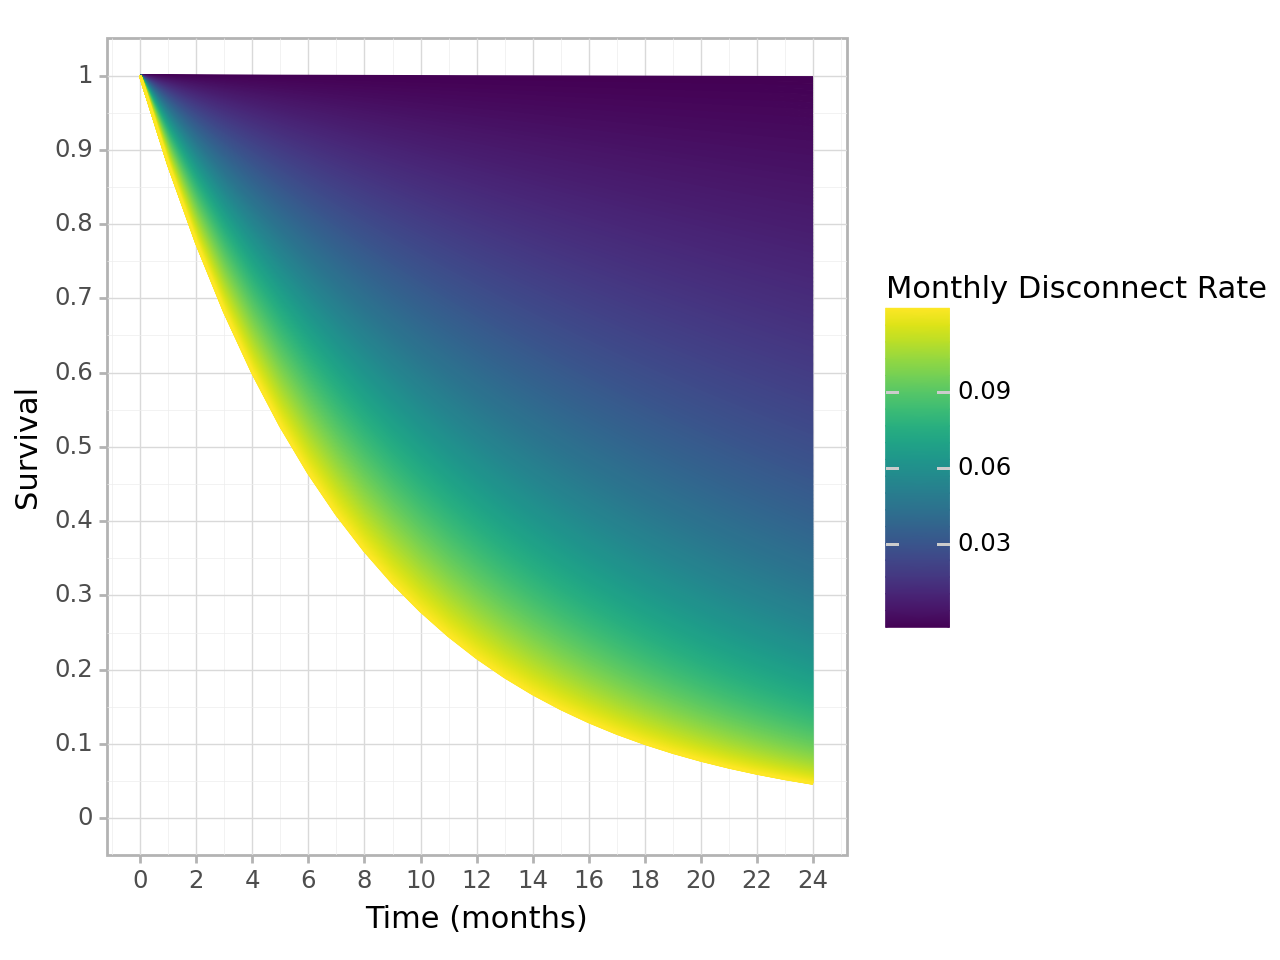

<Figure Size: (640 x 480)>

In [16]:
(
    ggplot(big_df)
    + aes(x='t')
    + geom_line(aes(y='survival', color='disconnect', group='disconnect'))
    + theme_light()
    + labs(color = 'Monthly Disconnect Rate')
    + xlab('Time (months)')
    + ylab('Survival')
    + scale_x_continuous(breaks=[2*x for x in range(0, 13)])
    + scale_y_continuous(breaks=[.1*x for x in range(0, 11)], limits=[0, 1])
)

In the plot above, we see that gradients created by the disconnect rate colors are not equally spaced. The higher the monthly disconnect rate, the closer the curves become. That is, there is a non-linear response to a linear increase in churn rate.

In [17]:
def find_churn_from_surve(df, val, t):
    """
    Returns the corresponding exponential churn rate for a given survival at a given time
    Args:
        df: dataframe of computed survival curves
        val: Value of survival curve at time t
        t: time t
    """
    df['search'] = (df.survival - val).apply(abs)
    return df[df.t == t].sort_values(['search'])['r'].head(1).item()

In [18]:
vals = []
for i in range(1, 20):
    vals.append(find_churn_from_surve(big_df, (100.0 - 5.0*i) / 100.0, 24))

In [19]:
ser = pd.Series(vals)

In [20]:
plot_df = big_df[big_df.r.isin(ser)]

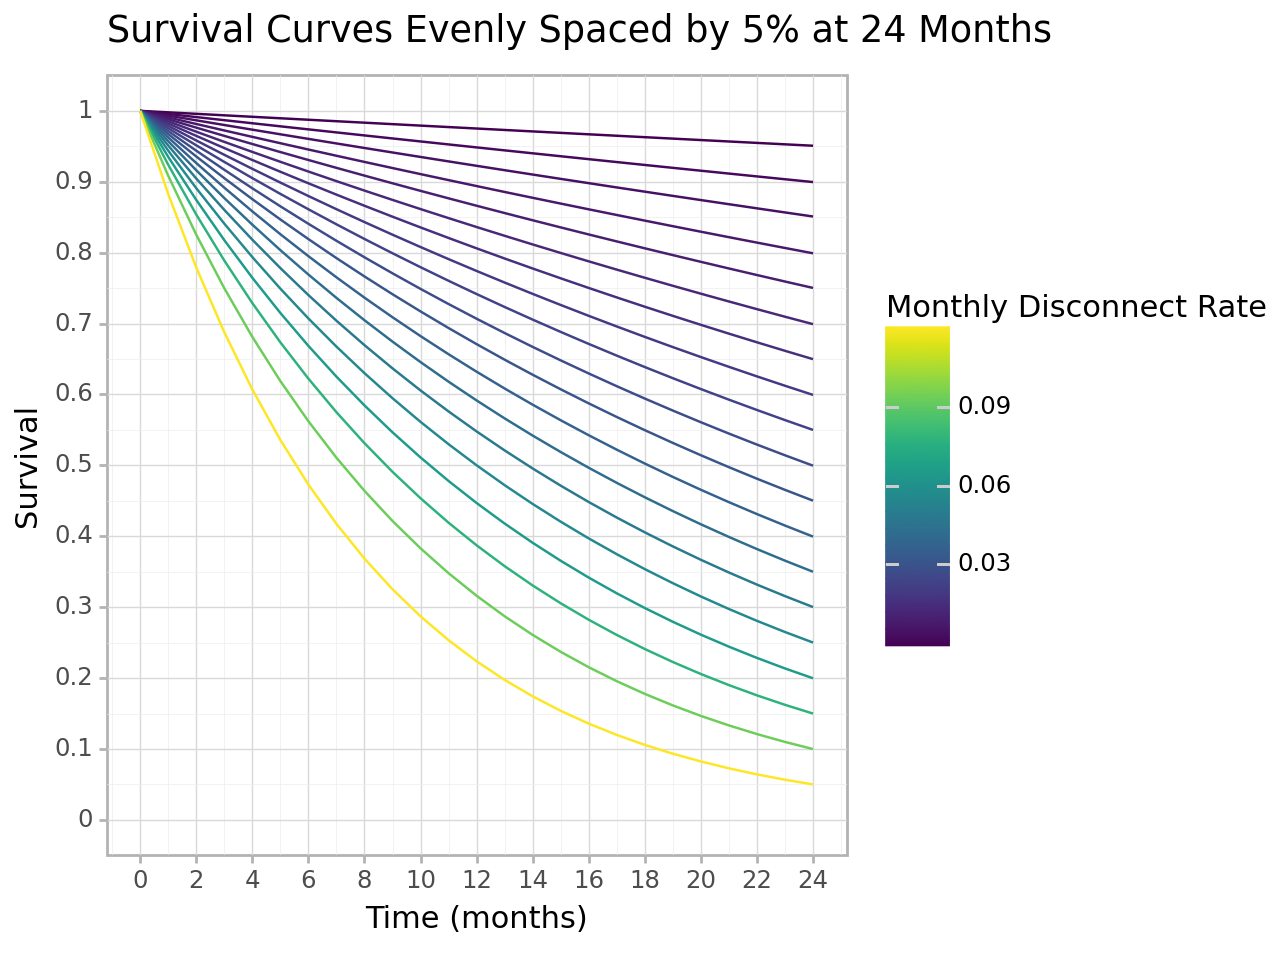

<Figure Size: (640 x 480)>

In [21]:
(
    ggplot(plot_df)
    + aes(x='t')
    + geom_line(aes(y='survival', color='disconnect', group='disconnect'))
    + theme_light()
    + labs(color = 'Monthly Disconnect Rate')
    + xlab('Time (months)')
    + ylab('Survival')
    + ggtitle('Survival Curves Evenly Spaced by 5% at 24 Months')
    + scale_x_continuous(breaks=[2*x for x in range(0, 13)])
    + scale_y_continuous(breaks=[.1*x for x in range(0, 11)], limits=[0, 1])
)

The plot above shows survival curves whose survival rate at 24 months are evenly spaced at 5%. We see the drastic change in curvature of the survival curves as the 24 month survival rate decreases.

In [22]:
sweet_spot_df = big_df[big_df.r.isin([250, 300, 350])]

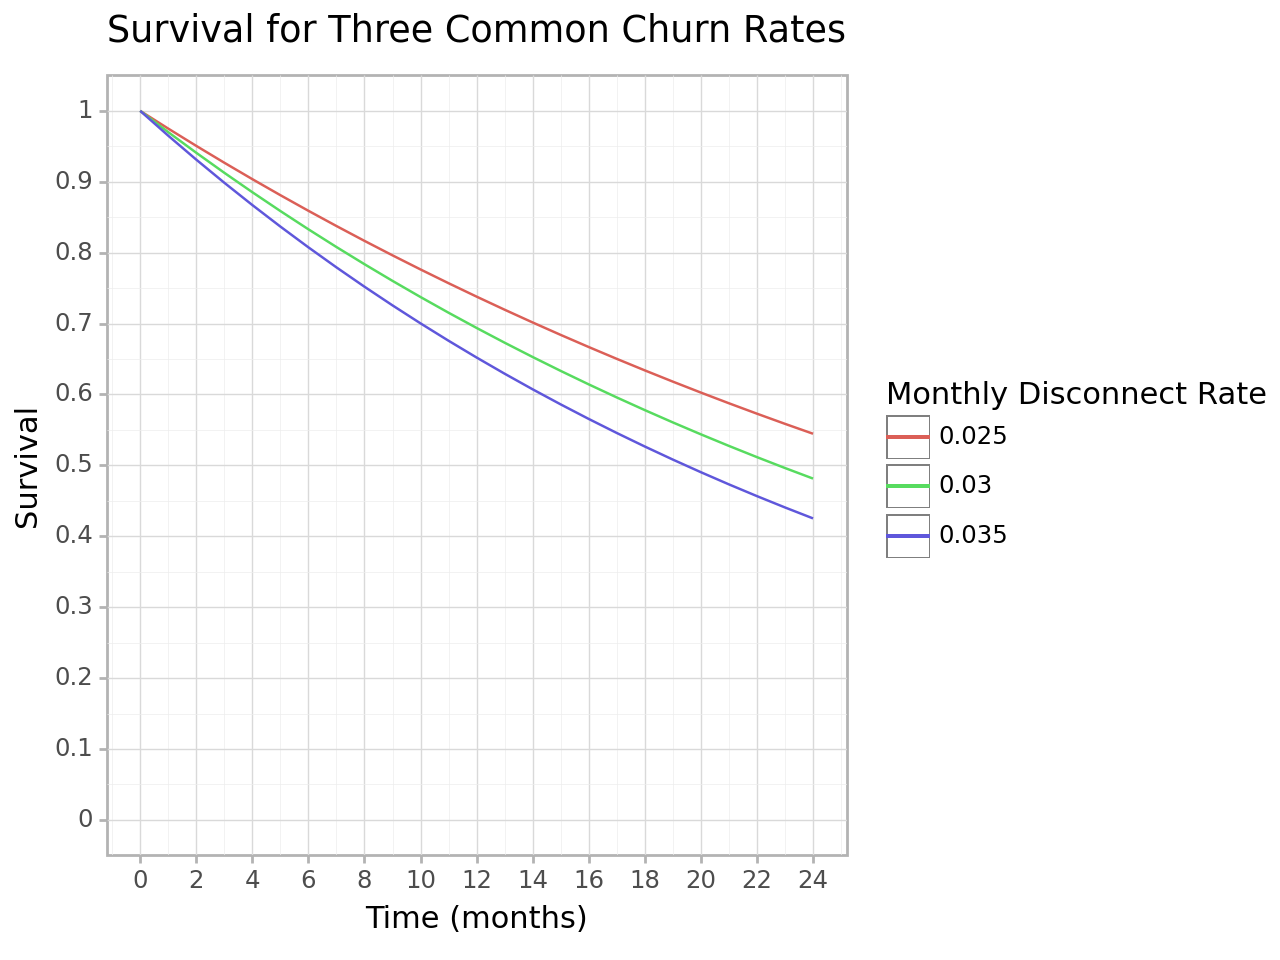

<Figure Size: (640 x 480)>

In [23]:
(
    ggplot(sweet_spot_df)
    + aes(x='t')
    + geom_line(aes(y='survival', color='disconnect.astype(str)', group='disconnect.astype(str)'))
    + xlab('Time (months)')
    + theme_light()
    + ylab('Survival')
    + labs(color = 'Monthly Disconnect Rate')
    + ggtitle('Survival for Three Common Churn Rates')
    + scale_x_continuous(breaks=[2*x for x in range(0, 13)])
    + scale_y_continuous(breaks=[.1*x for x in range(0, 11)], limits=[0,1])
)

# Table of Survival Curve Values

In [24]:
vals = []
for i in range(1, 20):
    vals.append((100 - 5*i, int(100 * 100 * -math.log(float(100 - 5*i) / 100) / 24 )))
df = pd.DataFrame(vals, columns=['Survival @ 24 Months', 'Basis Points'])
df['Basis Point Diff'] = df['Basis Points'].diff()
df

,Survival @ 24 Months,Basis Points,Basis Point Diff
0,95,21,NaN
1,90,43,22.0000
2,85,67,24.0000
3,80,92,25.0000
4,75,119,27.0000
5,70,148,29.0000
6,65,179,31.0000
7,60,212,33.0000
8,55,249,37.0000
9,50,288,39.0000


From the above table, we see that increasing the survival of a lower curve has a greater effect on basis point reduction than the same change for a higher survival curve. For example, efforts to change a population with survival 20% to 25% at 24 months would have a 93 basis point reduction, whereas a change from 75% to 80% at 24 months would have a 27 basis point reduction.

# Summary
The plots and tables above illustrate various relationships between churn rate and known quantities, such as gross adds and survival.